In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import pandas as pd
import numpy as np
import math

In [0]:
    transforms = transforms.Compose([transforms.ToTensor()])
    train_dataset = datasets.MNIST(
        './data',
        train=True,
        download=True,
        transform=transforms)

    test_dataset = datasets.MNIST(
        './data',
        train=False,
        download=True,
        transform=transforms
    )

In [0]:
    BATCH_SIZE = 128    
    N_EPOCHS = 250       
    INPUT_DIM = 784    
    HIDDEN_DIM = 512   
    LATENT_DIM = 2  
    lr = 0.001           

In [0]:
    train_iterator = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_iterator = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [0]:
  class DNAE(nn.Module):
        
        def __init__(self):
            super(DNAE, self).__init__()
      
            self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
            self.conv2 = nn.Conv2d(32, 16, 3, padding=1)
            self.conv3 = nn.Conv2d(16, 8, 3, padding=1)
            self.pool = nn.MaxPool2d(2, 2)
        
            self.t_conv1 = nn.ConvTranspose2d(8, 8, 3, stride=2)  
            self.t_conv2 = nn.ConvTranspose2d(8, 16, 2, stride=2)
            self.t_conv3 = nn.ConvTranspose2d(16, 32, 2, stride=2)
            self.conv_out = nn.Conv2d(32, 1, 3, padding=1)
                
        def forward(self, x):
            x = F.relu(self.conv1(x))
            x = self.pool(x)
            x = F.relu(self.conv2(x))
            x = self.pool(x)
            x = F.relu(self.conv3(x))
            x = self.pool(x) 

            ## decode ##
            x = F.relu(self.t_conv1(x))
            x = F.relu(self.t_conv2(x))
            x = F.relu(self.t_conv3(x))
            x = F.sigmoid(self.conv_out(x))
                
            return x

        

In [0]:
    # dnae
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = DNAE().to(device)

    # optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    criterion = nn.MSELoss()

In [0]:
 def train():
        model.train()

        train_loss = 0

        for x in train_iterator:
            images,labels = x
            noisy_images = images + torch.randn(*images.shape)
            noisy_images = np.clip(noisy_images,0.,1.)
            
            # update the gradients to zero
            optimizer.zero_grad()

            # forward pass
            result = model(noisy_images)

            # reconstruction loss
            loss = criterion(result,images)

            # backward pass
            loss.backward()
            train_loss += loss.item()*images.size(0)
            
            # update the weights
            optimizer.step()

        return train_loss

In [0]:
   best_test_loss = float('inf')

    for e in range(N_EPOCHS):

        train_loss = train()

        train_loss /= len(train_dataset)

        print(f'Epoch {e}, Train Loss: {train_loss:.2f}') 

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


"\n# plot the first ten input images and then reconstructed images\nfig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))\n\n# input images on top row, reconstructions on bottom\nfor noisy_imgs, row in zip([noisy_imgs, output], axes):\n    for img, ax in zip(noisy_imgs, row):\n        ax.imshow(np.squeeze(img), cmap='gray')\n        ax.get_xaxis().set_visible(False)\n        ax.get_yaxis().set_visible(False)\n"

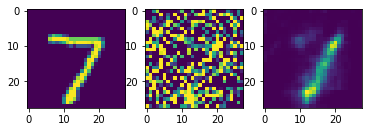

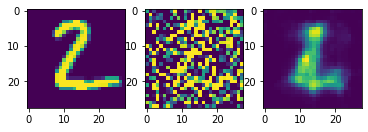

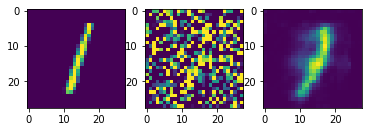

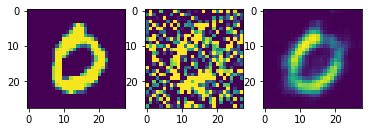

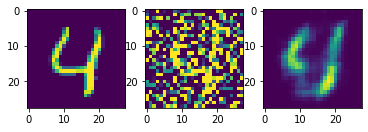

In [67]:
dataiter = iter(test_iterator)
images, labels = dataiter.next()

# add noise to the test images
noisy_imgs = images + torch.randn(*images.shape)
noisy_imgs = np.clip(noisy_imgs, 0., 1.)

# get sample outputs
output = model(noisy_imgs)
# prep images for display
noisy_imgs = noisy_imgs.numpy()

output = output.view(128, 1, 28, 28)
output = output.detach().numpy()

for i in range(5):
  f, axarr = plt.subplots(1,3)
  img = np.squeeze(images[i])
  oimg = np.squeeze(output[i])
  nimg = np.squeeze(noisy_imgs[i])
  axarr[0,].imshow(img)
  axarr[1,].imshow(nimg)
  axarr[2,].imshow(oimg)

